Retrieving the dataset

In [ ]:
# Configures the path of Kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# API to fetch dataset from Kaggle
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.27G/2.29G [00:13<00:00, 232MB/s]
100% 2.29G/2.29G [00:13<00:00, 187MB/s]


In [ ]:
# Extracting .zip file
from zipfile import ZipFile
file_name = '/content/chest-xray-pneumonia.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


Importing Libraries

In [1]:
import os
import itertools
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

Organizing the Training, Testing, and Validating

In [ ]:
train_data_dir = "/content/chest_xray/train"
filepaths = []
labels = []

folds = os.listdir(train_data_dir)
for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')

train_df = pd.concat([Fseries, Lseries], axis= 1)
train_df

# Keep the directories how they are

filepaths     labels
0     /content/chest_xray/train/PNEUMONIA/person1183...  PNEUMONIA
1     /content/chest_xray/train/PNEUMONIA/person1215...  PNEUMONIA
2     /content/chest_xray/train/PNEUMONIA/person1911...  PNEUMONIA
3     /content/chest_xray/train/PNEUMONIA/person1021...  PNEUMONIA
4     /content/chest_xray/train/PNEUMONIA/person849_...  PNEUMONIA
...                                                 ...        ...
5211  /content/chest_xray/train/NORMAL/NORMAL2-IM-06...     NORMAL
5212  /content/chest_xray/train/NORMAL/IM-0507-0001....     NORMAL
5213  /content/chest_xray/train/NORMAL/NORMAL2-IM-05...     NORMAL
5214  /content/chest_xray/train/NORMAL/NORMAL2-IM-06...     NORMAL
5215  /content/chest_xray/train/NORMAL/IM-0660-0001....     NORMAL

[5216 rows x 2 columns]

In [ ]:
test_data_dir = '/content/chest_xray/test'
filepaths = []
labels = []
folds = os.listdir(test_data_dir)
for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
test_df = pd.concat([Fseries, Lseries], axis= 1)
test_df

filepaths     labels
0    /content/chest_xray/test/PNEUMONIA/person1637_...  PNEUMONIA
1    /content/chest_xray/test/PNEUMONIA/person85_ba...  PNEUMONIA
2    /content/chest_xray/test/PNEUMONIA/person144_b...  PNEUMONIA
3    /content/chest_xray/test/PNEUMONIA/person158_b...  PNEUMONIA
4    /content/chest_xray/test/PNEUMONIA/person122_b...  PNEUMONIA
..                                                 ...        ...
619  /content/chest_xray/test/NORMAL/IM-0059-0001.jpeg     NORMAL
620  /content/chest_xray/test/NORMAL/NORMAL2-IM-028...     NORMAL
621  /content/chest_xray/test/NORMAL/IM-0041-0001.jpeg     NORMAL
622  /content/chest_xray/test/NORMAL/NORMAL2-IM-027...     NORMAL
623  /content/chest_xray/test/NORMAL/NORMAL2-IM-003...     NORMAL

[624 rows x 2 columns]

In [ ]:
val_data_dir = "/content/chest_xray/val"
filepaths = []
labels = []

for f in os.listdir(val_data_dir):
    foldpath = os.path.join(val_data_dir, f)
    for file in os.listdir(foldpath):
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(f)
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
valid_df = pd.concat([Fseries, Lseries], axis= 1)
valid_df

filepaths     labels
0   /content/chest_xray/val/PNEUMONIA/person1954_b...  PNEUMONIA
1   /content/chest_xray/val/PNEUMONIA/person1946_b...  PNEUMONIA
2   /content/chest_xray/val/PNEUMONIA/person1949_b...  PNEUMONIA
3   /content/chest_xray/val/PNEUMONIA/person1950_b...  PNEUMONIA
4   /content/chest_xray/val/PNEUMONIA/person1946_b...  PNEUMONIA
5   /content/chest_xray/val/PNEUMONIA/person1952_b...  PNEUMONIA
6   /content/chest_xray/val/PNEUMONIA/person1951_b...  PNEUMONIA
7   /content/chest_xray/val/PNEUMONIA/person1947_b...  PNEUMONIA
8   /content/chest_xray/val/NORMAL/NORMAL2-IM-1436...     NORMAL
9   /content/chest_xray/val/NORMAL/NORMAL2-IM-1430...     NORMAL
10  /content/chest_xray/val/NORMAL/NORMAL2-IM-1438...     NORMAL
11  /content/chest_xray/val/NORMAL/NORMAL2-IM-1437...     NORMAL
12  /content/chest_xray/val/NORMAL/NORMAL2-IM-1427...     NORMAL
13  /content/chest_xray/val/NORMAL/NORMAL2-IM-1431...     NORMAL
14  /content/chest_xray/val/NORMAL/NORMAL2-IM-1442...     NORMAL
15  /content/chest_xray/val/NORMAL/NORMAL2-IM-1440...     NORMAL

Visualizing the distribution

<Axes: xlabel='labels', ylabel='count'>

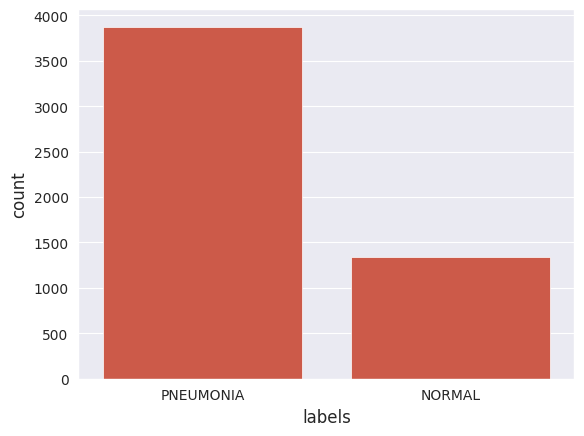

In [ ]:
sns.countplot(x=train_df.labels)

In [ ]:
# Processing images in batches
batch_size = 16
img_size = (224, 224)

# Creates data generators that load and preprocess the image data
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
val_gen= ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = val_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 5216 validated image filenames belonging to 2 classes.
Found 16 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


Displaying Images

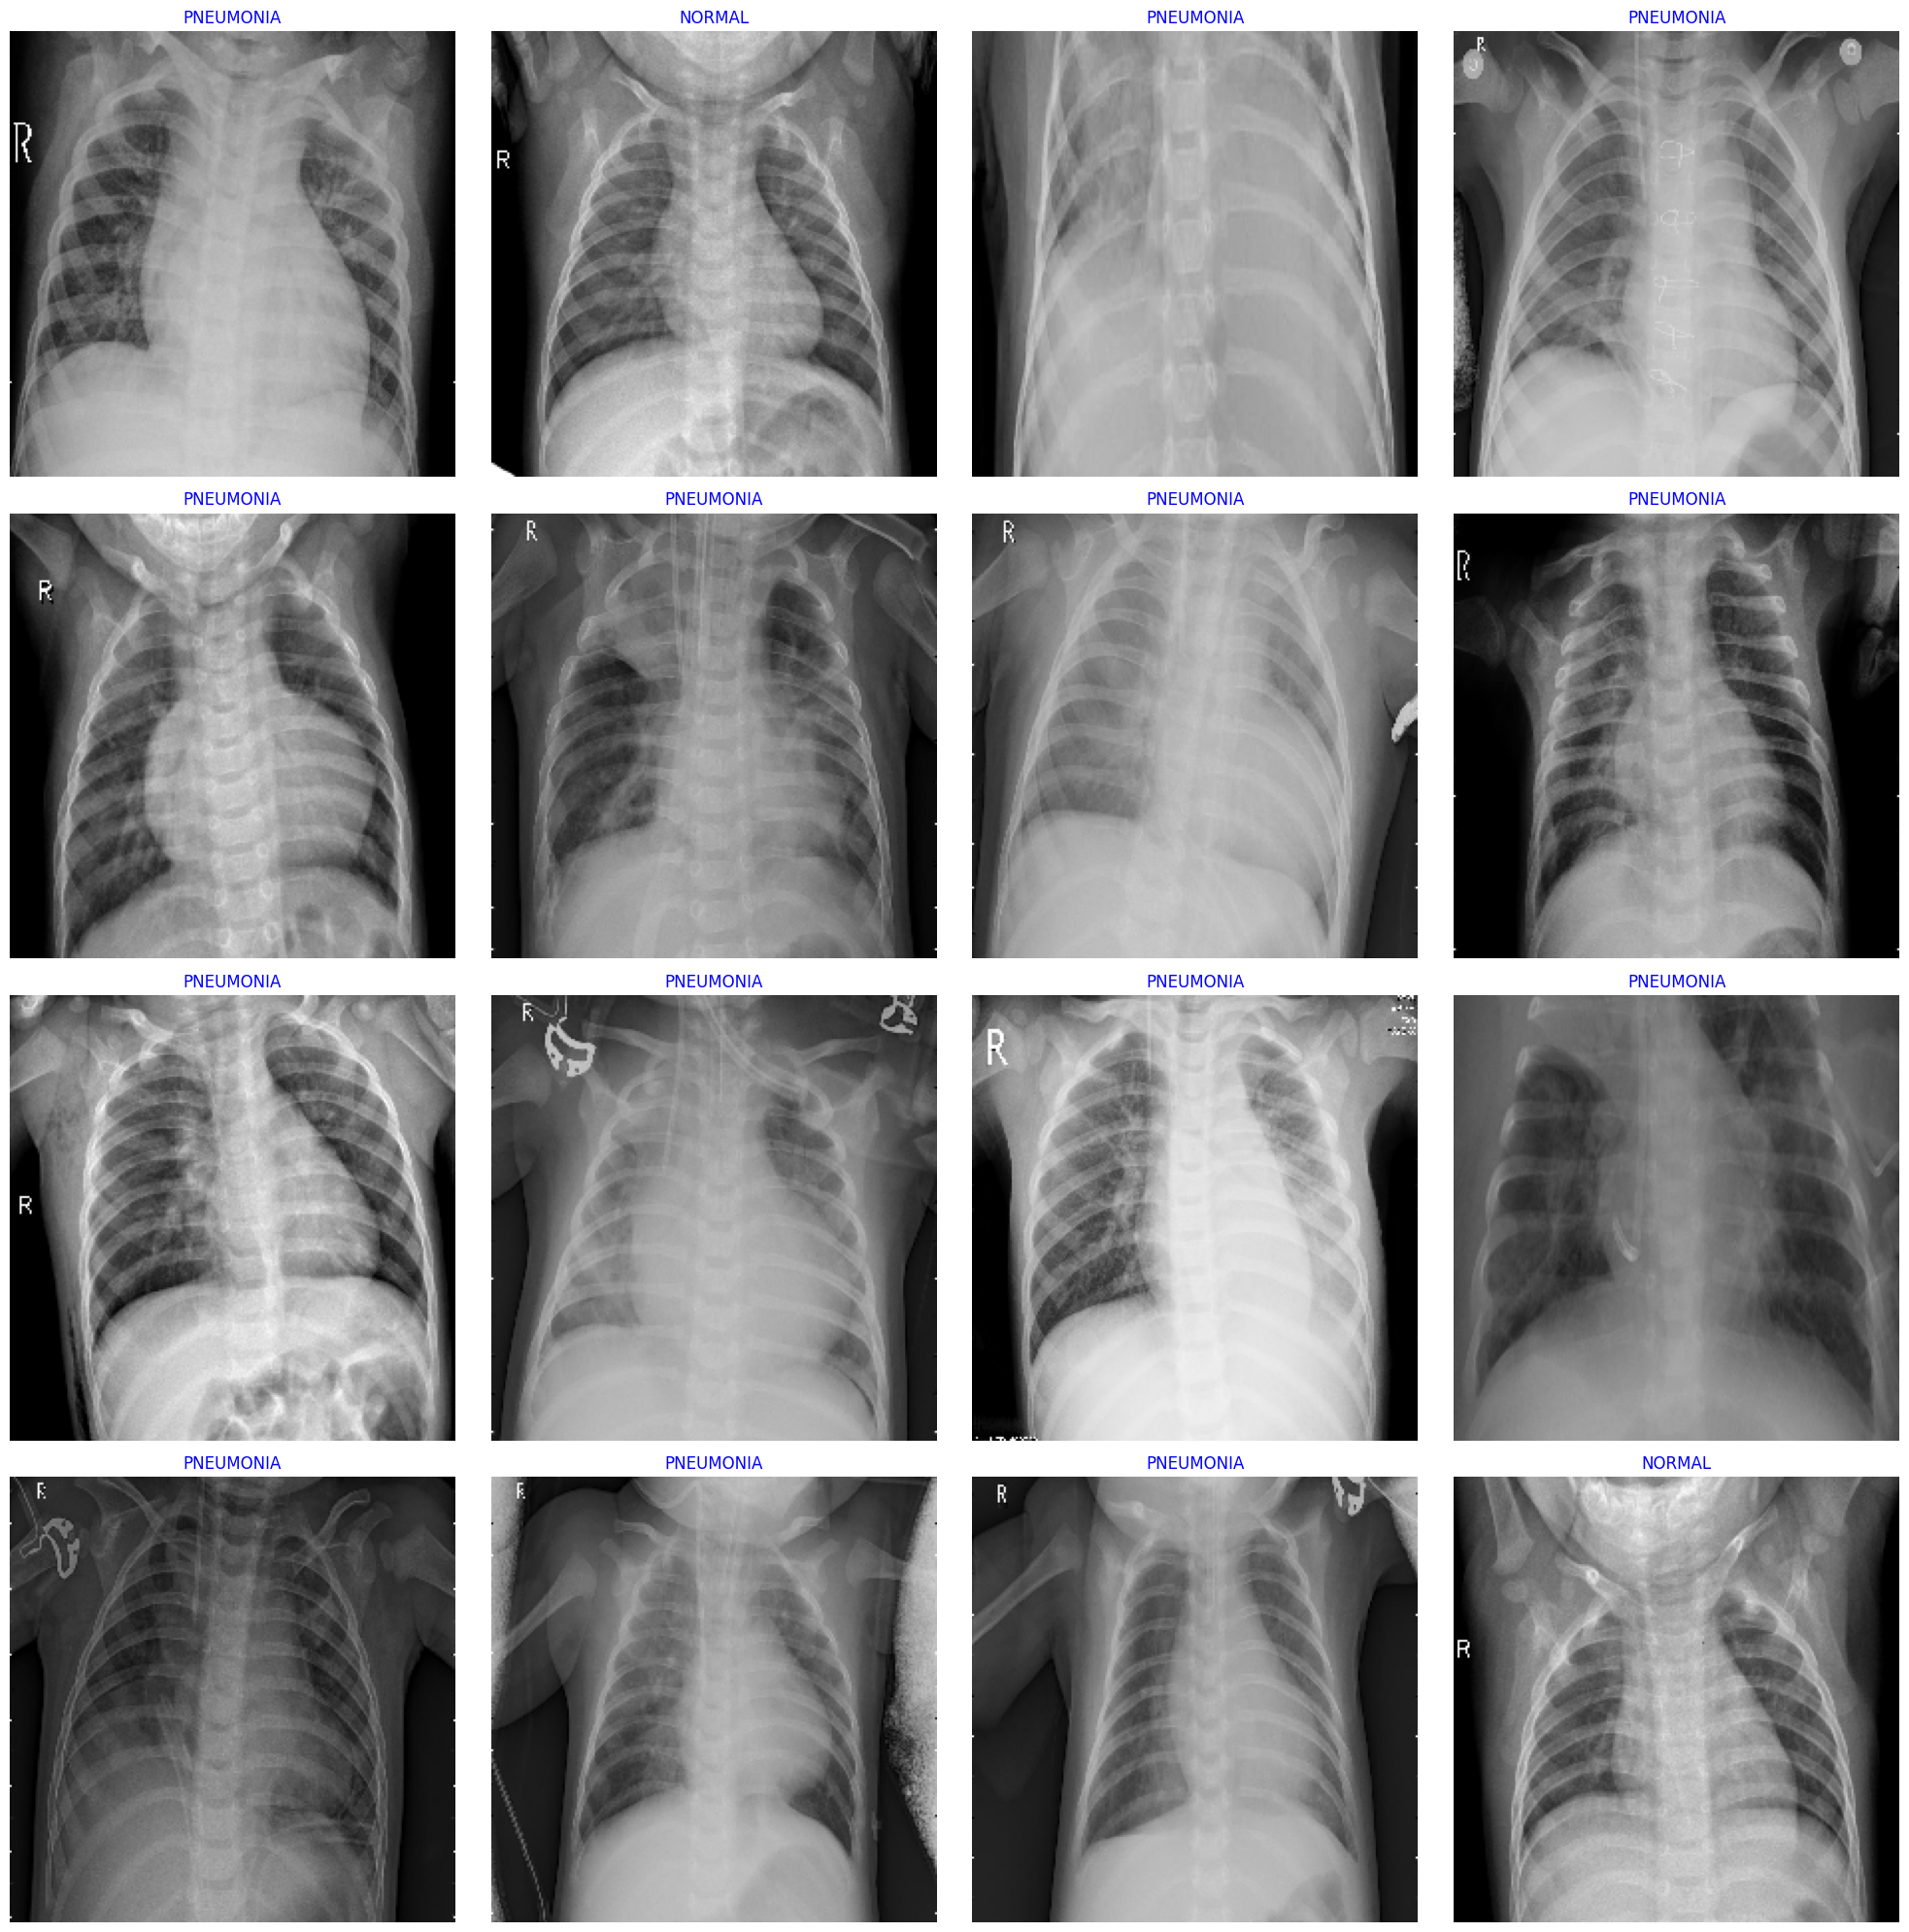

In [ ]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys()) # maps the categorical labels to numeric indicies
images, labels = next(train_gen)

plt.figure(figsize= (20, 20))

# Displays stuff
for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.tight_layout()
plt.show()

VGG19 Implementation

In [ ]:
# Loads VGG19
base_model = tf.keras.applications.VGG19(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freezes the base model for pretrained weights
base_model.trainable = False

# Adding a custom dense layer
model = Sequential([
    base_model, #
    Flatten(), # Converts into a 1d vector
    '''
    Add a fully connected layer with 256 units
    Introducing non-linearity through the ReLU activation function
    Add L2 regularization to prevent overfitting
    '''
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5), # Randomly drops 50% of neurons to improve generalizationa and prevents overfitting
    Dense(2, activation='softmax') # Final dense layer
])

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Preparing the model for training in Keras

In [ ]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

'''
ADAM as an optimizer
Cateogrical crossentropy as a loss function
Model will evaluate its performance using accuracy as a metric
'''

Model Training

In [ ]:
history = model.fit(train_gen, validation_data=valid_gen, epochs=14)

Epoch 1/14
326/326 ━━━━━━━━━━━━━━━━━━━━ 3578s 11s/step - accuracy: 0.9089 - loss: 8.4725 - val_accuracy: 1.0000 - val_loss: 1.2484
Epoch 2/14
326/326 ━━━━━━━━━━━━━━━━━━━━ 3554s 11s/step - accuracy: 0.9635 - loss: 1.1699 - val_accuracy: 1.0000 - val_loss: 0.7785
Epoch 3/14
326/326 ━━━━━━━━━━━━━━━━━━━━ 3567s 11s/step - accuracy: 0.9483 - loss: 0.9518 - val_accuracy: 1.0000 - val_loss: 0.7928
Epoch 4/14
326/326 ━━━━━━━━━━━━━━━━━━━━ 3560s 11s/step - accuracy: 0.9527 - loss: 0.7737 - val_accuracy: 1.0000 - val_loss: 0.6879
Epoch 5/14
326/326 ━━━━━━━━━━━━━━━━━━━━ 3587s 11s/step - accuracy: 0.9654 - loss: 0.5896 - val_accuracy: 1.0000 - val_loss: 0.3945
Epoch 6/14
326/326 ━━━━━━━━━━━━━━━━━━━━ 3578s 11s/step - accuracy: 0.9609 - loss: 0.4370 - val_accuracy: 1.0000 - val_loss: 0.2976
Epoch 7/14
326/326 ━━━━━━━━━━━━━━━━━━━━ 3625s 11s/step - accuracy: 0.9489 - loss: 0.3862 - val_accuracy: 1.0000 - val_loss: 0.2930
Epoch 8/14
326/326 ━━━━━━━━━━━━━━━━━━━━ 3620s 11s/step - accuracy: 0.9378 - loss: 0

Saving model

In [ ]:
model.save('pneumonia_model.h5')

'''
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('pneumonia_model.h5')
'''

"\nfrom tensorflow.keras.models import load_model\n\n# Load the saved model\nmodel = load_model('pneumonia_model.h5')\n"

Training and Validation Loss and Accuracy visualization

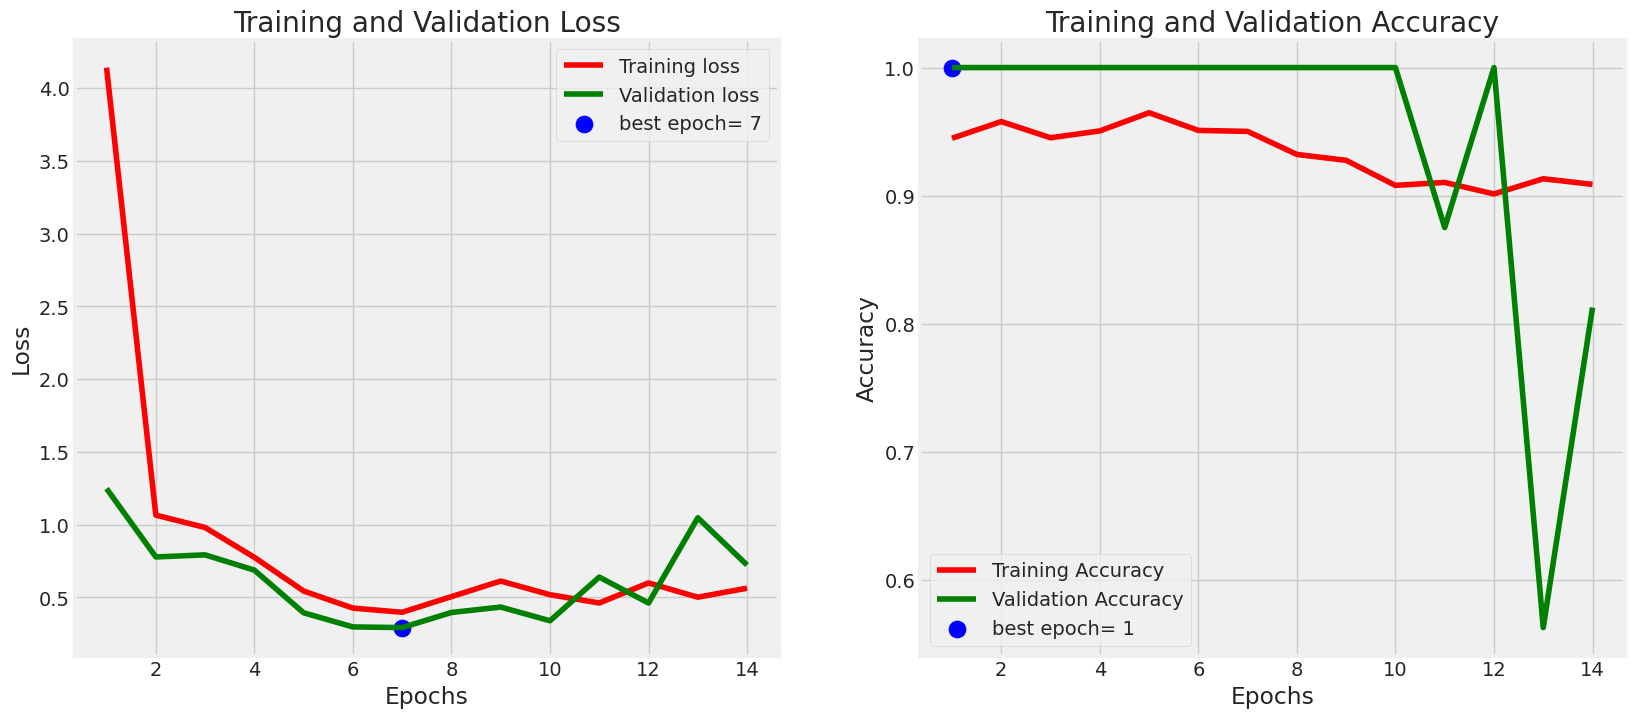

In [ ]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

Statistics

In [ ]:
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

326/326 ━━━━━━━━━━━━━━━━━━━━ 3579s 11s/step - accuracy: 0.9765 - loss: 0.5298
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.8125 - loss: 0.7228
39/39 ━━━━━━━━━━━━━━━━━━━━ 426s 11s/step - accuracy: 0.9244 - loss: 0.9878
Train Loss:  0.5324486494064331
Train Accuracy:  0.9739263653755188
--------------------
Validation Loss:  0.7228376865386963
Validation Accuracy:  0.8125
--------------------
Test Loss:  2.3802452087402344
Test Accuracy:  0.7099359035491943


Precision, recall, and f1 score

In [ ]:
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = test_gen.classes

print(classification_report(y_true, y_pred_classes, target_names=test_gen.class_indices.keys()))

conf_matrix = confusion_matrix(y_true, y_pred_classes)

39/39 ━━━━━━━━━━━━━━━━━━━━ 425s 11s/step
              precision    recall  f1-score   support

      NORMAL       0.98      0.23      0.37       234
   PNEUMONIA       0.68      1.00      0.81       390

    accuracy                           0.71       624
   macro avg       0.83      0.61      0.59       624
weighted avg       0.80      0.71      0.65       624



CFM

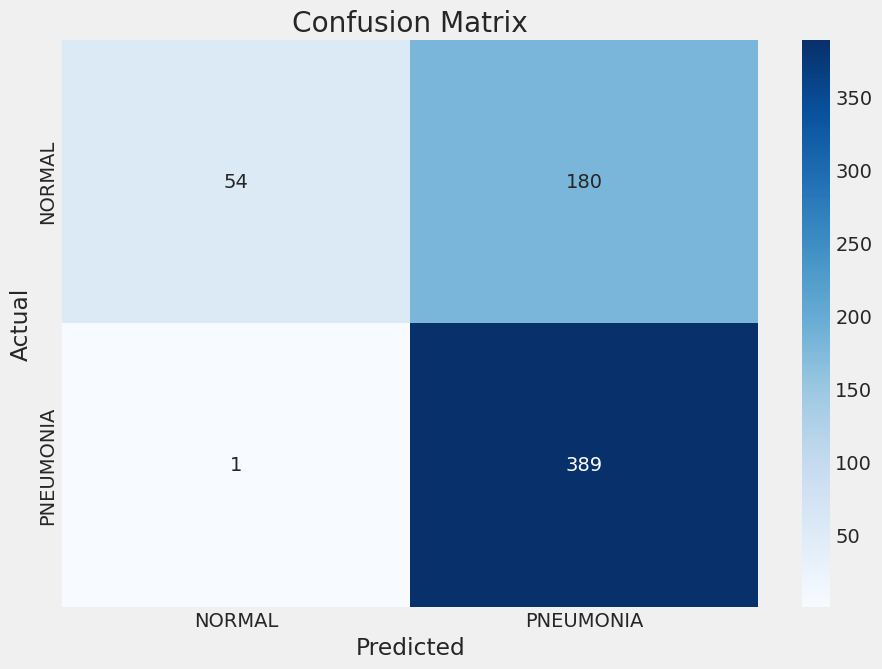

In [ ]:
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

Testing

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━

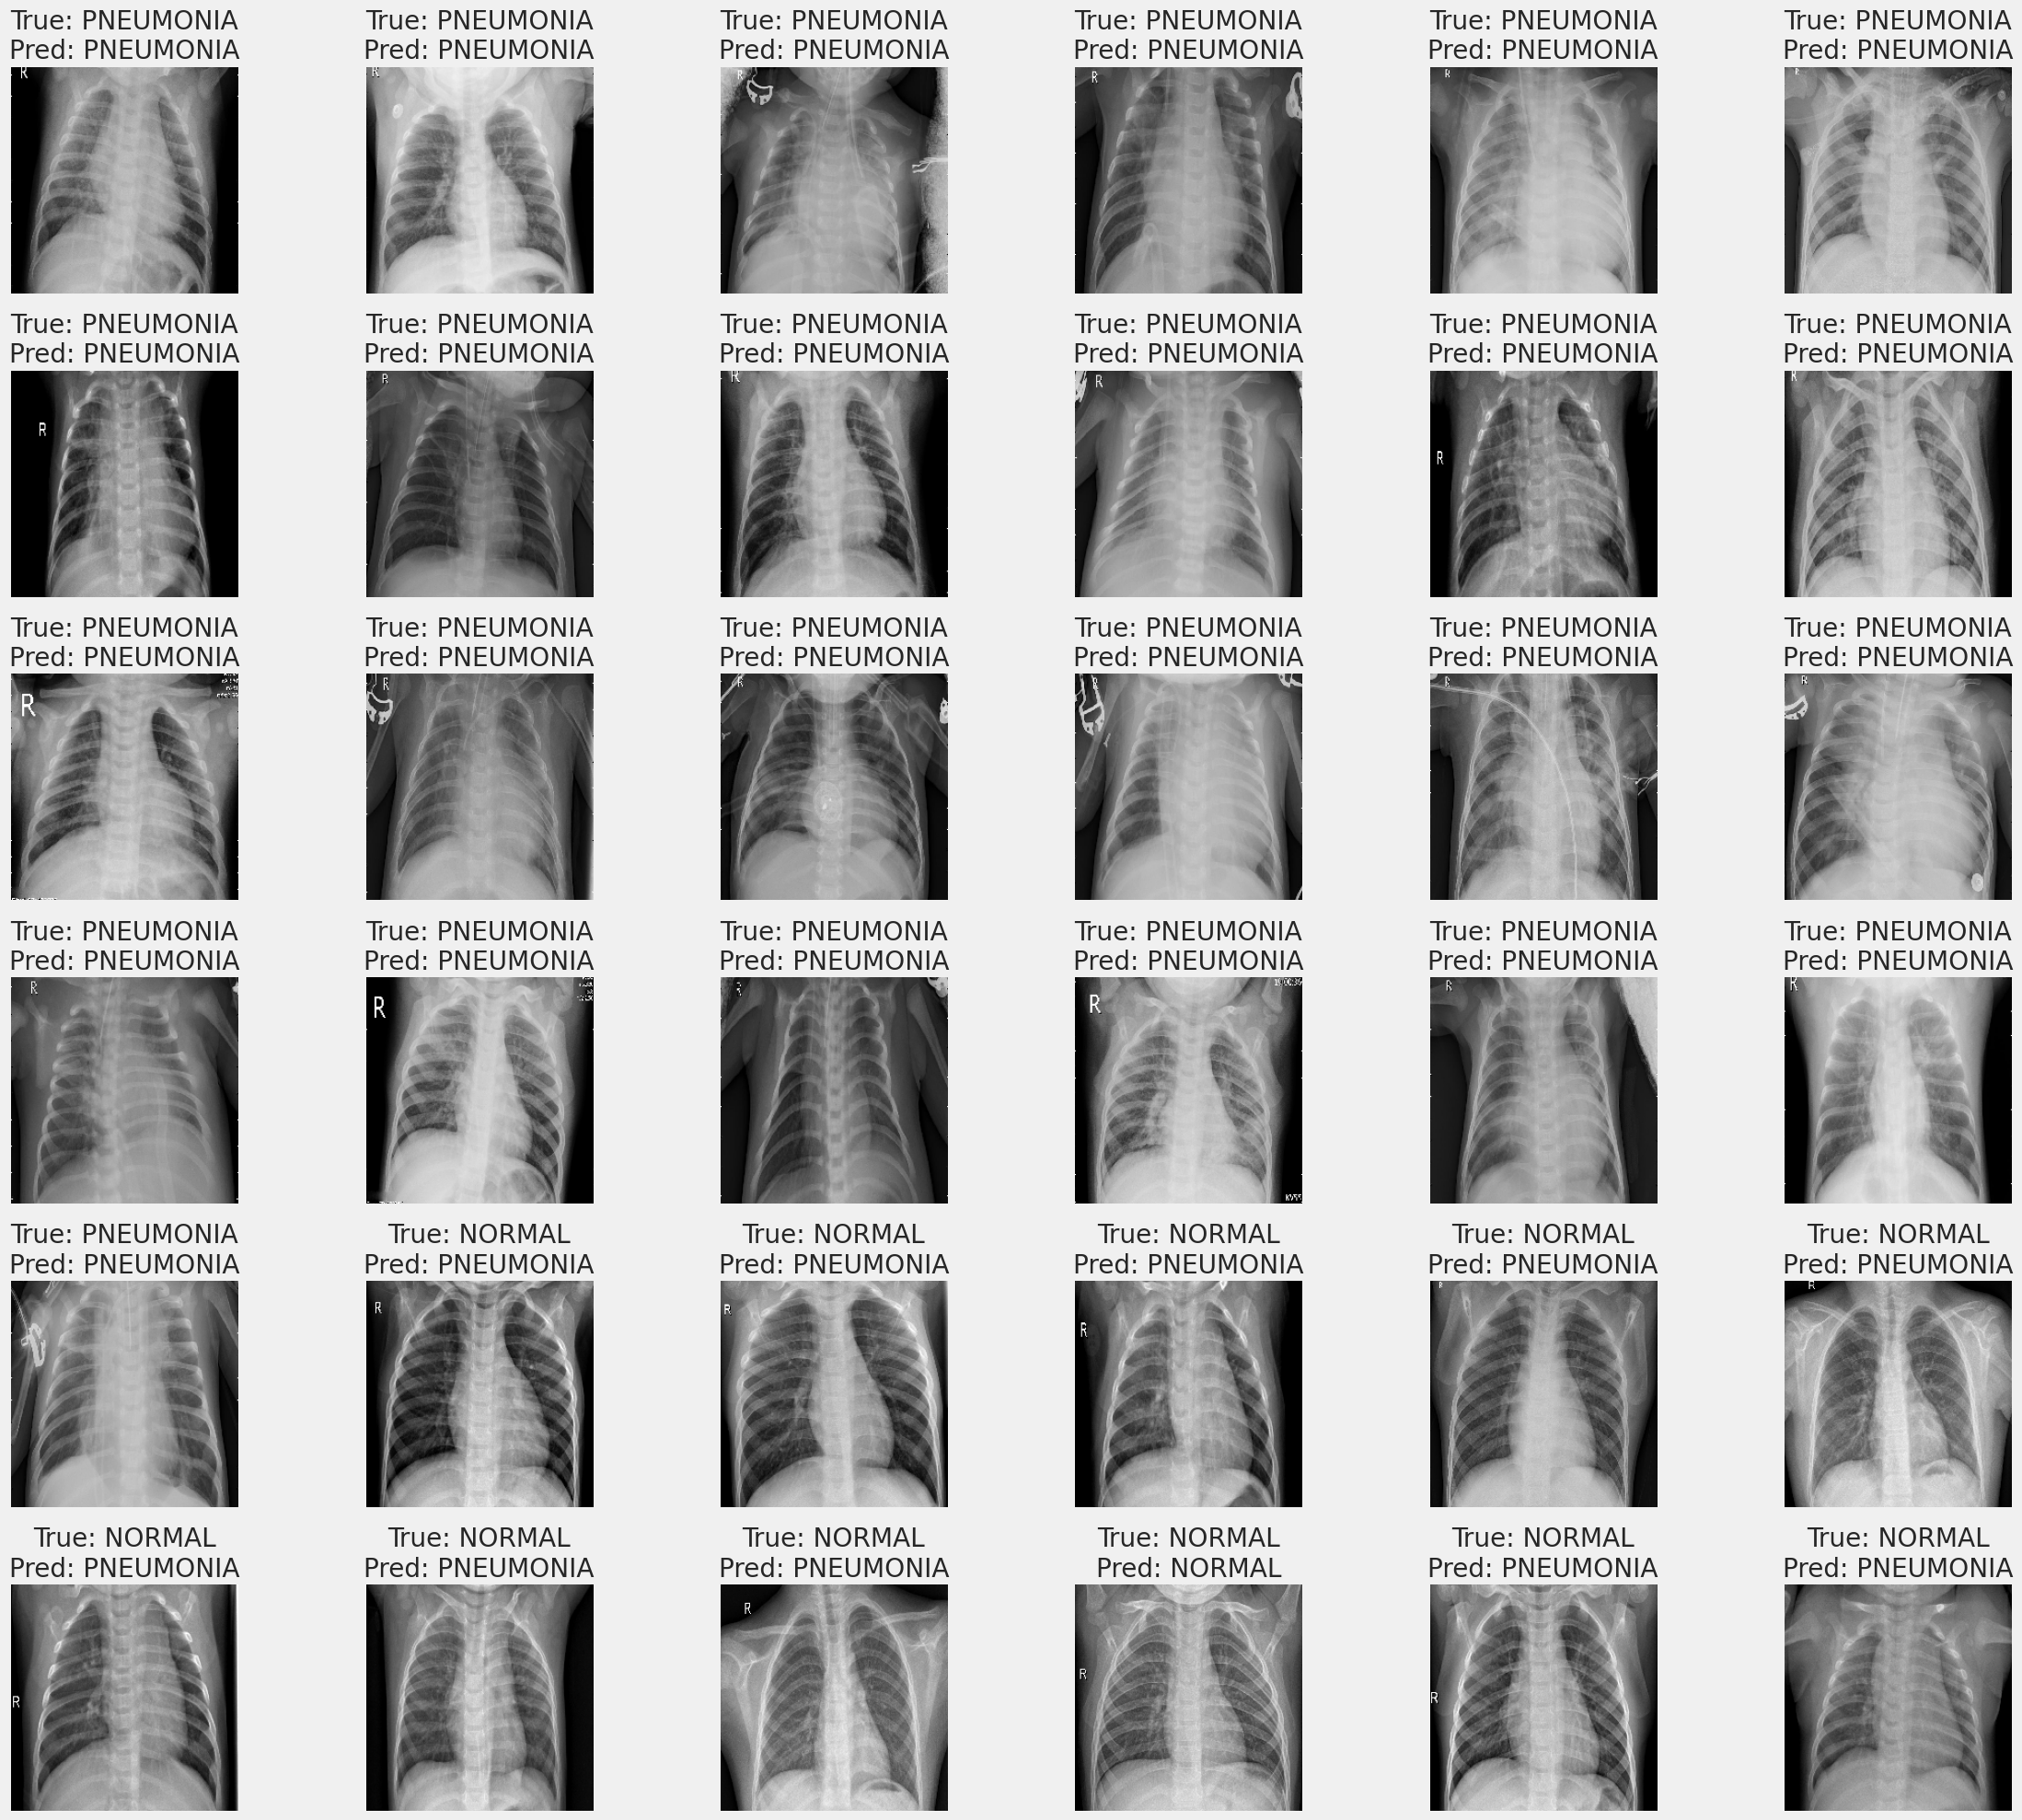

In [ ]:
plt.figure(figsize=(24,20))
for i in range(36):
    img, label = next(test_gen)
    predicted_probs = model.predict(img)
    predicted_label = np.argmax(predicted_probs[0])
    plt.subplot(6, 6, i+1)
    plt.imshow(img[0]/255)
    true_label = list(test_gen.class_indices.keys())[np.argmax(label[0])]
    predicted_label_name = list(test_gen.class_indices.keys())[predicted_label]

    plt.title(f'True: {true_label}\nPred: {predicted_label_name}')
    plt.axis('off')
plt.tight_layout()
plt.show()